#Problem Statement:

Dream Housing Finance company deals in all home loans. They have a presence across all urban, semi-urban, and rural areas. Customer-first applies for a home loan after that company validates the customer eligibility for a loan.

The company wants to automate the loan eligibility process (real-time) based on customer detail provided while filling the online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History, and others. To automate this process, they have given a problem to identify the customer's segments, those are eligible for loan amount so that they can specifically target these customers. Here they have provided a partial data set.

Importing the Libraries

In [ ]:
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import chi2_contingency

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier

from sklearn.metrics import accuracy_score,precision_score,recall_score,classification_report,confusion_matrix,f1_score,make_scorer,roc_auc_score

import optuna
import pickle

import warnings
warnings.filterwarnings('ignore')

Loading the Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/Loan Eligibility Dataset/loan-train.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [ ]:
#Dropping unnecessary columns

df.drop('Loan_ID', axis = 1, inplace = True)

Exploring the Data

In [ ]:
#data info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 57.7+ KB


In [ ]:
#Check for duplicated entries

df.duplicated().sum()

0

In [ ]:
#Data types of data

df.dtypes

Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [ ]:
#Data size

print('Dataset contains {0} rows and {1} columns'.format(df.shape[0], df.shape[1]))

Dataset contains 614 rows and 12 columns


In [ ]:
#Number of unique values

df.nunique()

Gender                 2
Married                2
Dependents             4
Education              2
Self_Employed          2
ApplicantIncome      505
CoapplicantIncome    287
LoanAmount           203
Loan_Amount_Term      10
Credit_History         2
Property_Area          3
Loan_Status            2
dtype: int64

In [ ]:
#Dataset numeric values description

df.describe().T

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.00,81000.0
CoapplicantIncome,614.0,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,592.0,146.412162,85.587325,9.0,100.0,128.0,168.00,700.0
Loan_Amount_Term,600.0,342.000000,65.120410,12.0,360.0,360.0,360.00,480.0
Credit_History,564.0,0.842199,0.364878,0.0,1.0,1.0,1.00,1.0


#Summary
1. **ApplicantIncome:**<br>
  There are 614 non null entries in the "ApplicantIncome" column. The mean income is 5403.46 with a significant standard deviation of 6109.04, indicating a wide dispersion of income levels. The minimum income is 150, while the maximum is 81000.0, illustrating a diverse range of income values in the dataset.

2. **CoapplicantIncome:** <br>
  The "CoapplicantIncome" column has 614 non null entries.The mean coapplicant income is 1621.25, with a standard deviation of 2926.25.The data reveals a diverse distribution, ranging from 0.0 to 41667.0.

3. **LoanAmount:**<br>
  There are 592 non-null values in the "LoanAmount" column. The average loan amount is 146.41, with a standard deviation of 85.59. The range spans from a minimum of 9.0 to a maximum of 700.0, showcasing variability in loan amounts.

4. **Loan_Amount_Term:**<br>
  The "Loan_Amount_Term" column comprises 600 non null entries. The mean loan term is 342 months, with a standard deviation of 65.12. The majority of loan terms are for 360 months (30 years).

5. **Credit_History:**<br>
  The "Credit_History" column has 564 non-null values. The mean credit history value is 0.842, indicating that, on average, most applicants have a credit history. The data suggests a binary nature, with values predominantly at 0 or 1.

In [ ]:
#Dataset categorical values description

df.describe(include='object').T

,count,unique,top,freq
Gender,601,2,Male,489
Married,611,2,Yes,398
Dependents,599,4,0,345
Education,614,2,Graduate,480
Self_Employed,582,2,No,500
Property_Area,614,3,Semiurban,233
Loan_Status,614,2,Y,422


In [ ]:
#Value counts for categorical columns having more than 2 unique values

print(df['Dependents'].value_counts(), end="\n\n")
print(df['Property_Area'].value_counts())

0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64

Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64


#Summary
1. **Gender:**<br>
There are 601 non null entries in the "Gender" column. There are two unique values: Male and Female. Male is the most frequent gender, occurring 489 times.

2. **Married:**<br>
The "Married" column has 611 non null entries. There are two unique values: Yes and No. Yes is the most common marital status, with 398 occurrences.

3. **Dependents:**<br>
There are 599 non null entries in the "Dependents" column. There are four unique values: 0, 1, 2, and 3+. The majority of applicants have 0 dependents, occurring 345 times.

4. **Education:**<br>
All 614 in the "Education" column are unique. There are two unique values: Graduate and Not Graduate. The majority of applicants are graduates, with 480 occurrences.

5. **Self_Employed:**<br>
The "Self_Employed" column has 582 non null entries. There are two unique values: Yes and No. No is the more common status, with 500 occurrences.

6. **Property_Area:**<br>
All 614 entries in the "Property_Area" column are unique. There are three unique values: Semiurban, Urban, and Rural. Semiurban is the most common property area, with 233 occurrences, followed by Urban (202) and Rural (179).

7. **Loan_Status:**<br>
All 614 entries in the "Loan_Status" column are unique. There are two unique values: Y (Yes) and N (No). The majority of applicants have been granted a loan, with 422 occurrences.


In [ ]:
#Percentage and number of missing values

def missing(df):
  missing_number = df.isnull().sum().sort_values(ascending = False)
  missing_percentage = (df.isnull().mean() * 100).sort_values(ascending = False)
  output = pd.concat([missing_number, missing_percentage], axis = 1, keys = ['Missing Count', 'Missing Percentage'])
  styled_output = output.style.background_gradient(subset = ['Missing Count', 'Missing Percentage'], cmap = 'Reds' )
  return styled_output

missing(df)

,Missing Count,Missing Percentage
Credit_History,50,8.143322
Self_Employed,32,5.211726
LoanAmount,22,3.583062
Dependents,15,2.442997
Loan_Amount_Term,14,2.280130
Gender,13,2.117264
Married,3,0.488599
Education,0,0.000000
ApplicantIncome,0,0.000000
CoapplicantIncome,0,0.000000


<Axes: >

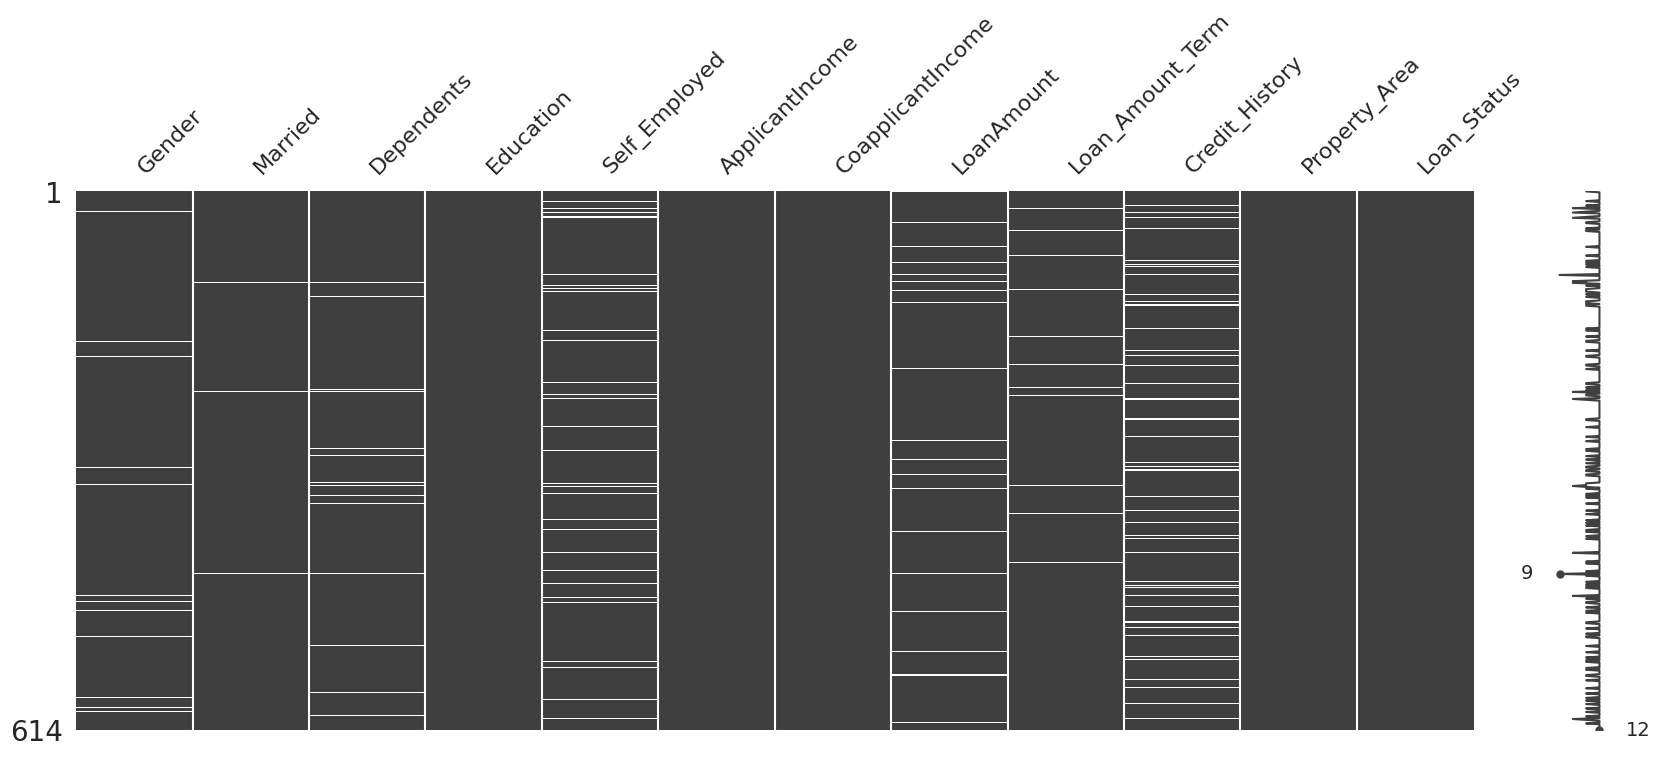

In [ ]:
#Missing values Visualization in data
msno.matrix(df, figsize=(20,7))


During the initial assessment of our data, we observed the presence of missing values in 7 out of 12 columns. The extent of missing values varies across these columns, with the highest percentage (8.14%) found in the "Credit_History" column and the lowest (0.4%) in the "Married" column.

Given that the missing values percentage is not excessively high, we plan to address this issue through imputation methods. This strategic decision allows us the flexibility to choose the most suitable statistical methods for each column, ensuring a robust approach to handling missing data without compromising the integrity of our analysis.

#Handling Missing Values

In [ ]:
#Filling the missing values with the most suitable statistical methods for each column

df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace = True)
df['Self_Employed'].fillna(df['Self_Employed'].mode()[0], inplace = True)
df['Dependents'].fillna(df['Dependents'].mode()[0], inplace = True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0], inplace = True)
df['Gender'].fillna(df['Gender'].mode()[0], inplace = True)
df['Married'].fillna(df['Married'].mode()[0], inplace = True)
df['LoanAmount'].fillna(df['LoanAmount'].mean(), inplace = True)

In [ ]:
#Checking whether null values have been imputed

df.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

Filled the null values with the most suitable statistical methods for each column

#Visualizing Outliers

In [ ]:
#Creating a function of visualizing outliers using box and distribution plots

def plot_hist_box(data, column):
    fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (15, 4))
    sns.histplot(data = data, x = column, bins = 20, kde = True, ax = ax1, color = '#FBE7A3', edgecolor='k')
    sns.boxplot(data = data, x = column, ax = ax2, color = '#3498db')
    ax1.set_title(f"Histogram and Box Plot of {column}", size = 15, weight = 'bold')
    ax1.set_xlabel(column, size = 12, weight = 'bold')
    ax1.set_ylabel("Frequency", size = 12, weight = 'bold')
    ax2.set_xlabel(column, size = 12, weight = 'bold')
    ax2.set_ylabel("Value", size = 12, weight = 'bold')
    plt.show()

In [ ]:
#Creating a function to print the number of outliers in a column

def count_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (data[column] < lower_bound) | (data[column] > upper_bound)
    print(f"Number of outliers in column '{column}': {outliers.sum()}")

In [ ]:
#Creating a function to remove outliers

def drop_outliers(data, columns):
    old_shape = data.shape
    for column in columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    new_shape = data.shape
    return old_shape, new_shape, data

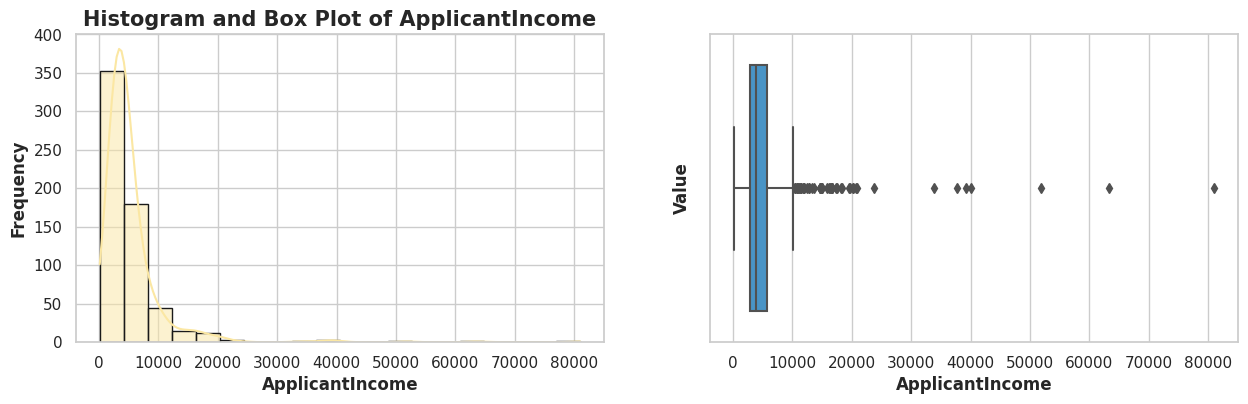

In [ ]:
plot_hist_box(df, 'ApplicantIncome')

In [ ]:
count_outliers(df, 'ApplicantIncome')

Number of outliers in column 'ApplicantIncome': 50


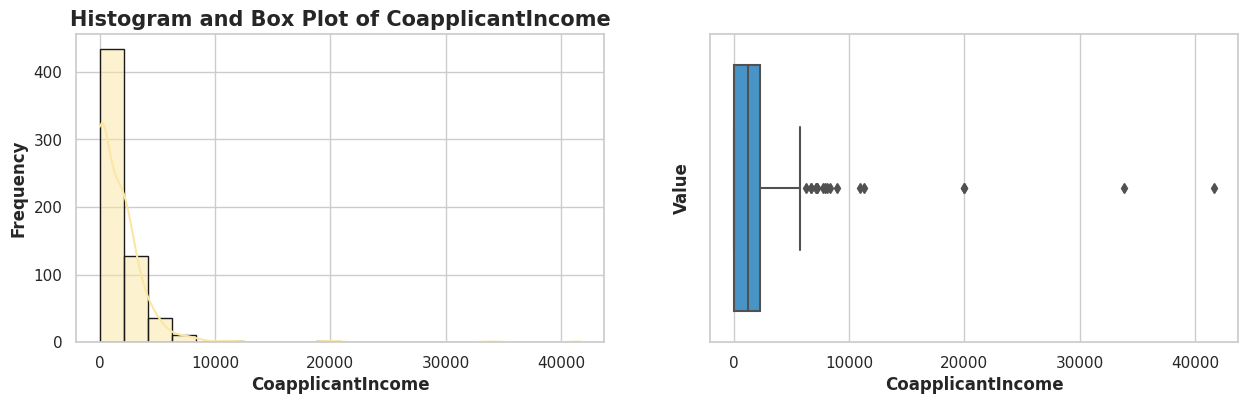

In [ ]:
plot_hist_box(df, 'CoapplicantIncome')

In [ ]:
count_outliers(df, 'CoapplicantIncome')

Number of outliers in column 'CoapplicantIncome': 18


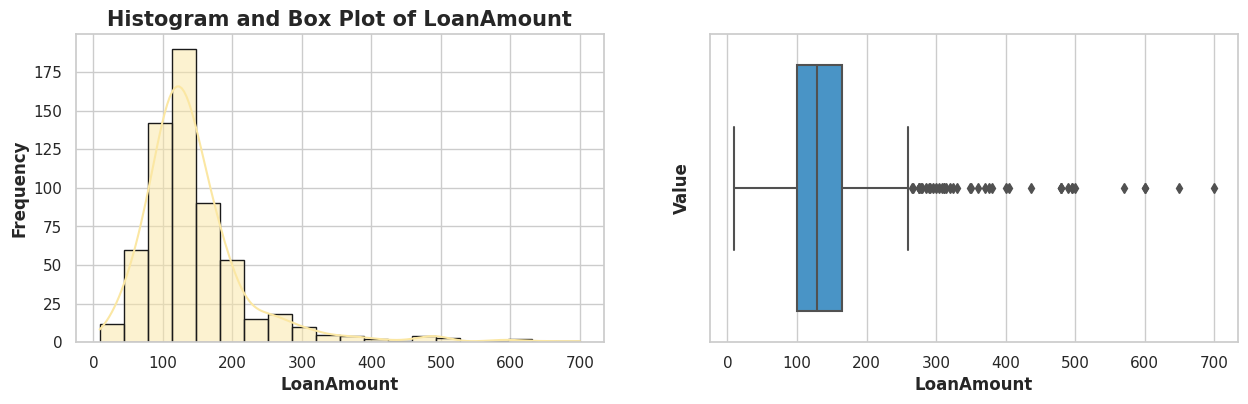

In [ ]:
plot_hist_box(df, 'LoanAmount')

In [ ]:
count_outliers(df, 'LoanAmount')

Number of outliers in column 'LoanAmount': 41


#Removing Outliers

In [ ]:
columns_to_check = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
old_shape, new_shape, df = drop_outliers(df, columns_to_check)
print(f'Old Shape : {old_shape}')
print(f'New Shape : {new_shape}')

Old Shape : (614, 12)
New Shape : (520, 12)


##Visulaizing the data

In [ ]:
#User defined function for visualizing Categorical entries

def catplot(df, x, explode = None):
  colors=['#FBE7A3', '#FFFFFF', '#AED6F1', '#82E0AA']
  sns.set(style='white')
  fig = plt.subplots(1,3,figsize = (20, 5))
  title = x + ' vs Loan_Status'
  plt.suptitle(title)

  plt.subplot(1,3,1)
  df[x].value_counts().plot.pie(explode = explode, autopct = '%1.1f%%', textprops = {'fontsize': '7'}, startangle=90, shadow=True,
                                         wedgeprops={'edgecolor': 'black'}, colors = colors)

  plt.subplot(1,3,2)
  ax = sns.histplot(data=df, x=x, color = colors[0], edgecolor = 'k')
  ax.bar_label(ax.containers[0])

  plt.subplot(1,3,3)
  ax = sns.countplot(data = df, x = x, hue = 'Loan_Status', palette = colors[:2], edgecolor = 'k')
  for container in ax.containers:
    ax.bar_label(container)

In [ ]:
#User defined function for visualizing continuous values

def numplot(df,x,scale):
  colors=['#FBE7A3', '#FFFFFF']
  sns.set(style='whitegrid')
  fig=plt.subplots(2,1,figsize=(16,12))

  plt.subplot(2,1,1)
  ax=sns.histplot(data=df, x=x, kde=True, color=colors[0], edgecolor='k')
  ax.bar_label(ax.containers[0])
  title = x +' distribution'
  plt.title(title)

  plt.subplot(2,1,2)
  tar = x+'_group'
  Tstr = str(scale)
  tit2 = x+' vs Loan_Status ( '+Tstr+' :1 )'
  dum_df=df.copy()
  dum_df[tar]=[int(i/scale) for i in dum_df[x]]
  colors={'Y' : '#FBE7A3', 'N' : '#FFFFFF'}
  ax=sns.countplot(data=dum_df, x=tar, hue='Loan_Status', palette=colors, edgecolor='k')
  for container in ax.containers:
    ax.bar_label(container)
  plt.title(tit2)

In [ ]:
#User defined function to print the loan approval rate for each unique value in a specified column

def approval_rate(df, col_name):
  df = df[df[col_name].notnull()]
  unique = df[col_name].unique()
  unique.sort()
  for i in unique:
    total = df[df[col_name] == i].shape[0]
    approved = df[(df[col_name] == i) & (df['Loan_Status'] == 'Y') ].shape[0]
    rate = (approved / total)*100
    print('Approval rate for "{0} : {1}" applicants is {2:.2f}%'.format(col_name,i , rate))

In [ ]:
#user defined function to calculate and print approval rates for different groups in continuous value column

def group_approval_rate(df, x, scale):
   print('After grouping {0} in {1} scale'.format(x, scale))
   tar = x+'_group'
   dum_df=df.copy()
   dum_df[tar]=[int(i/scale) for i in dum_df[x]]
   unique_groups = dum_df[tar].unique()
   unique_groups.sort()
   for i in unique_groups:
     total = dum_df[dum_df[tar] == i].shape[0]
     approved = dum_df[(dum_df[tar] == i) & (dum_df['Loan_Status'] == 'Y') ].shape[0]
     rate = (approved / total)*100
     print('  Approval rate for "{0} : {1}" applicants is {2:.2f}%'.format(tar,i , rate))

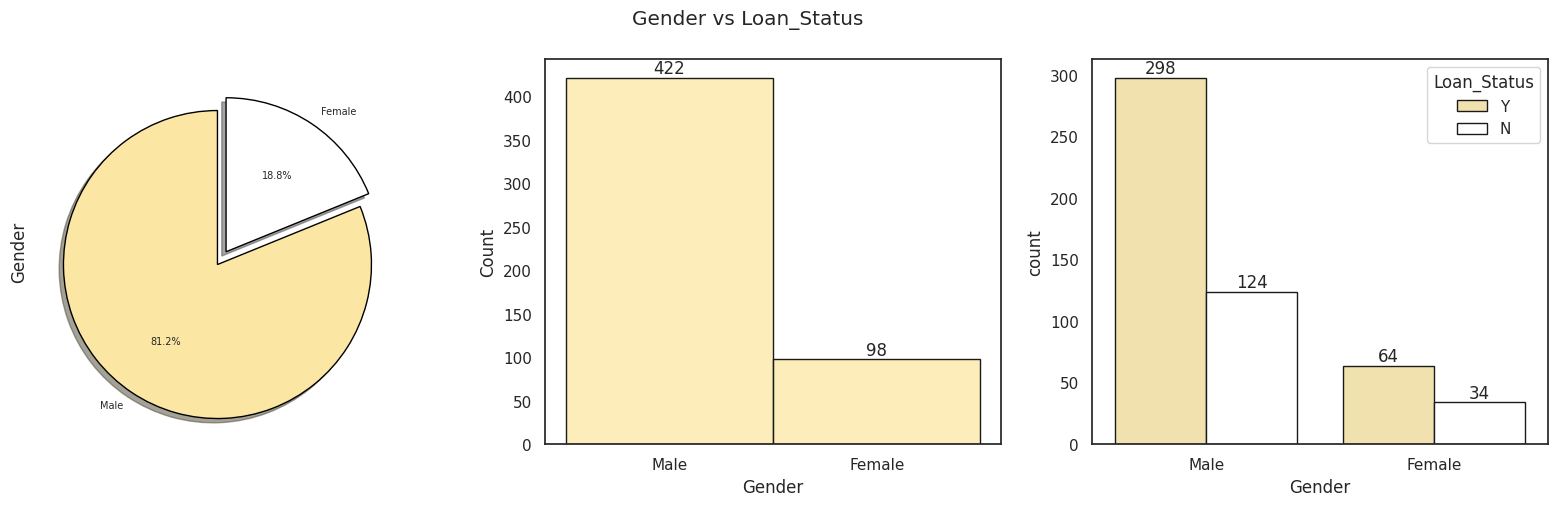

In [ ]:
catplot(df, 'Gender', explode = [0.1,0])

In [ ]:
approval_rate(df, 'Gender')

Approval rate for "Gender : Female" applicants is 65.31%
Approval rate for "Gender : Male" applicants is 70.62%


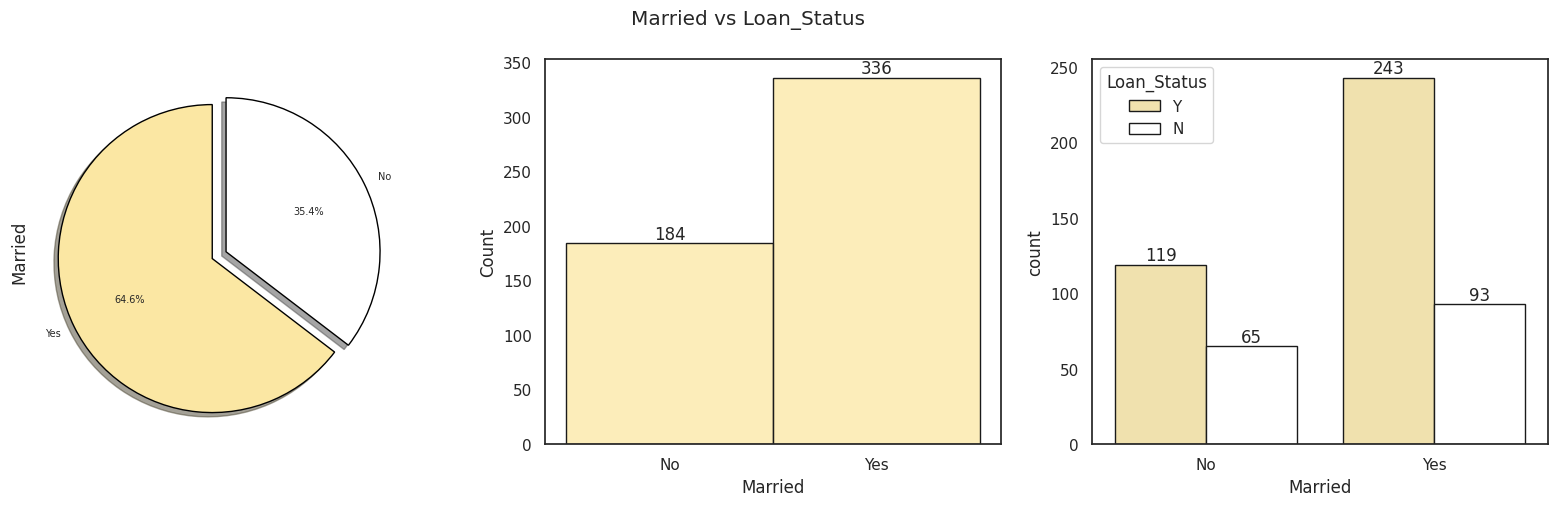

In [ ]:
catplot(df, 'Married', explode = [0.1,0])

In [ ]:
approval_rate(df, 'Married')

Approval rate for "Married : No" applicants is 64.67%
Approval rate for "Married : Yes" applicants is 72.32%


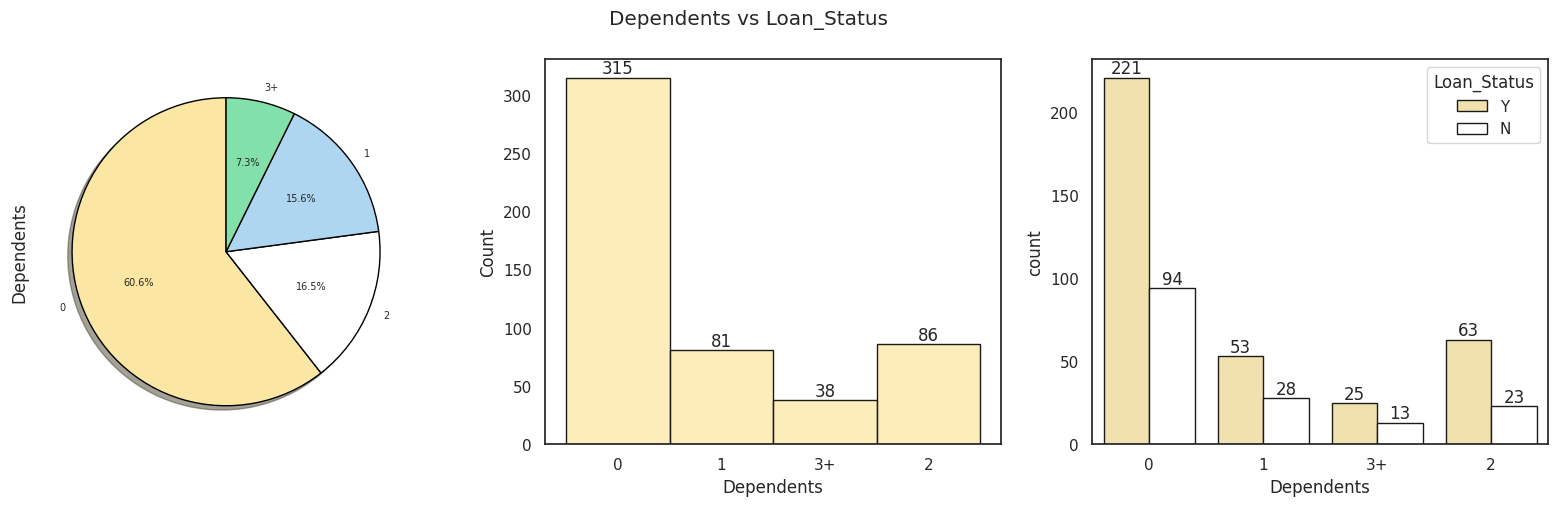

In [ ]:
catplot(df, 'Dependents')

In [ ]:
approval_rate(df, 'Dependents')

Approval rate for "Dependents : 0" applicants is 70.16%
Approval rate for "Dependents : 1" applicants is 65.43%
Approval rate for "Dependents : 2" applicants is 73.26%
Approval rate for "Dependents : 3+" applicants is 65.79%


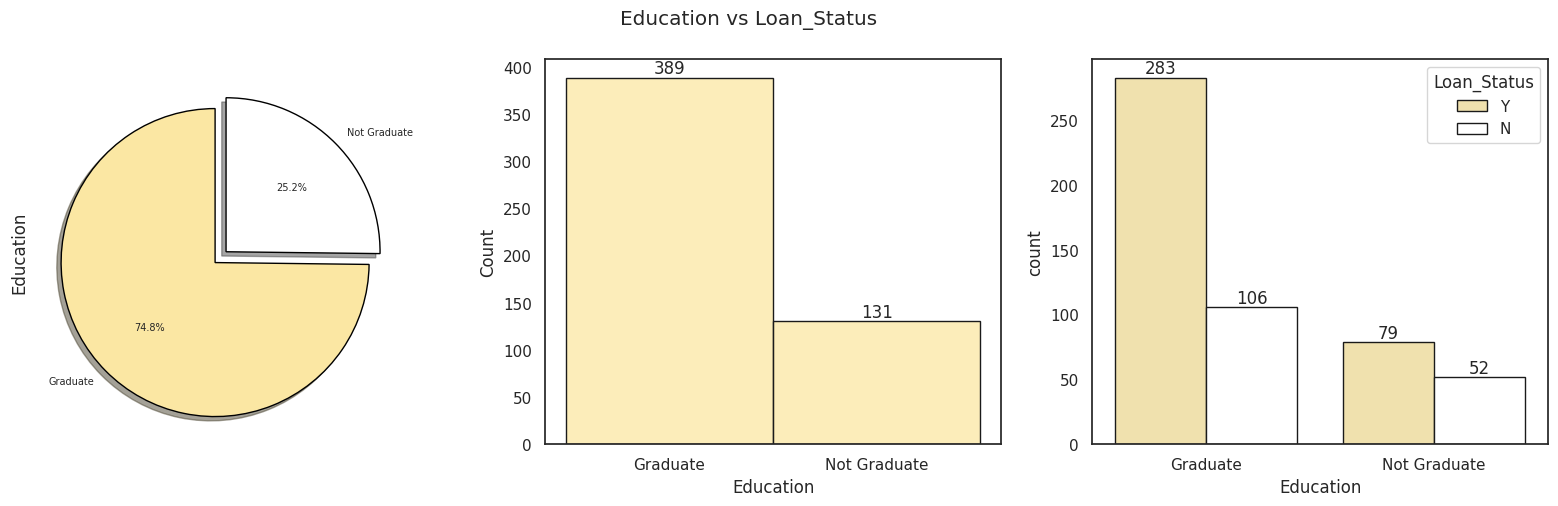

In [ ]:
catplot(df, 'Education', explode = [0.1,0])

In [ ]:
approval_rate(df, 'Education')

Approval rate for "Education : Graduate" applicants is 72.75%
Approval rate for "Education : Not Graduate" applicants is 60.31%


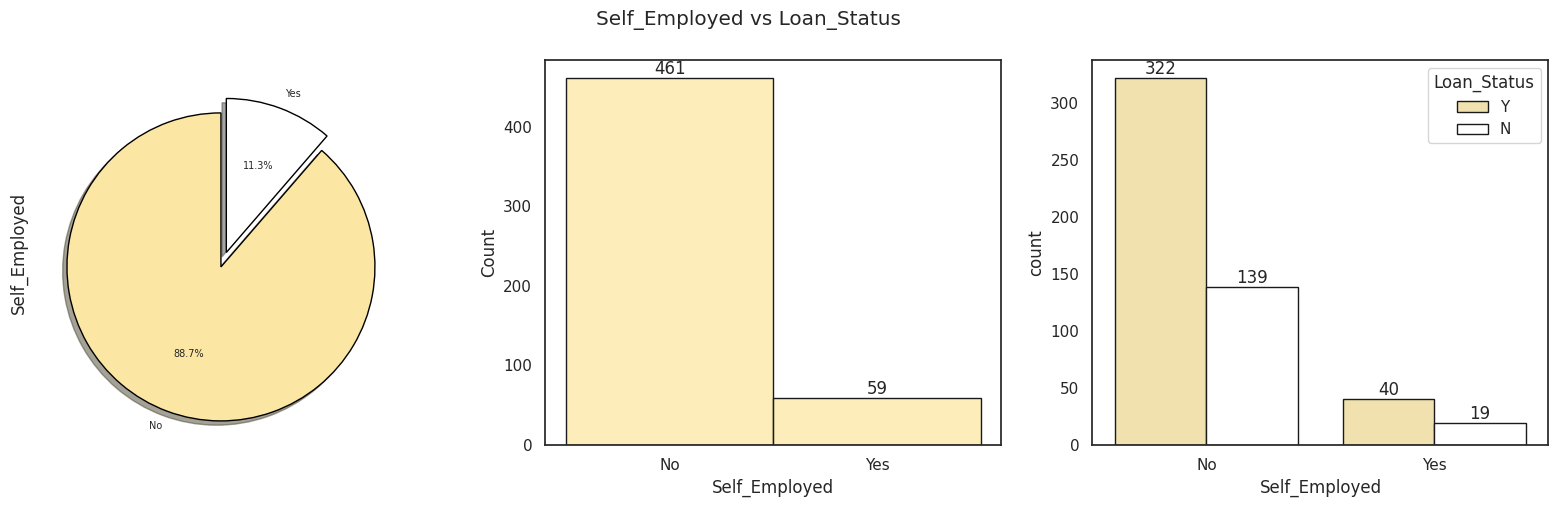

In [ ]:
catplot(df, 'Self_Employed', explode = [0.1,0])

In [ ]:
approval_rate(df, 'Self_Employed')

Approval rate for "Self_Employed : No" applicants is 69.85%
Approval rate for "Self_Employed : Yes" applicants is 67.80%


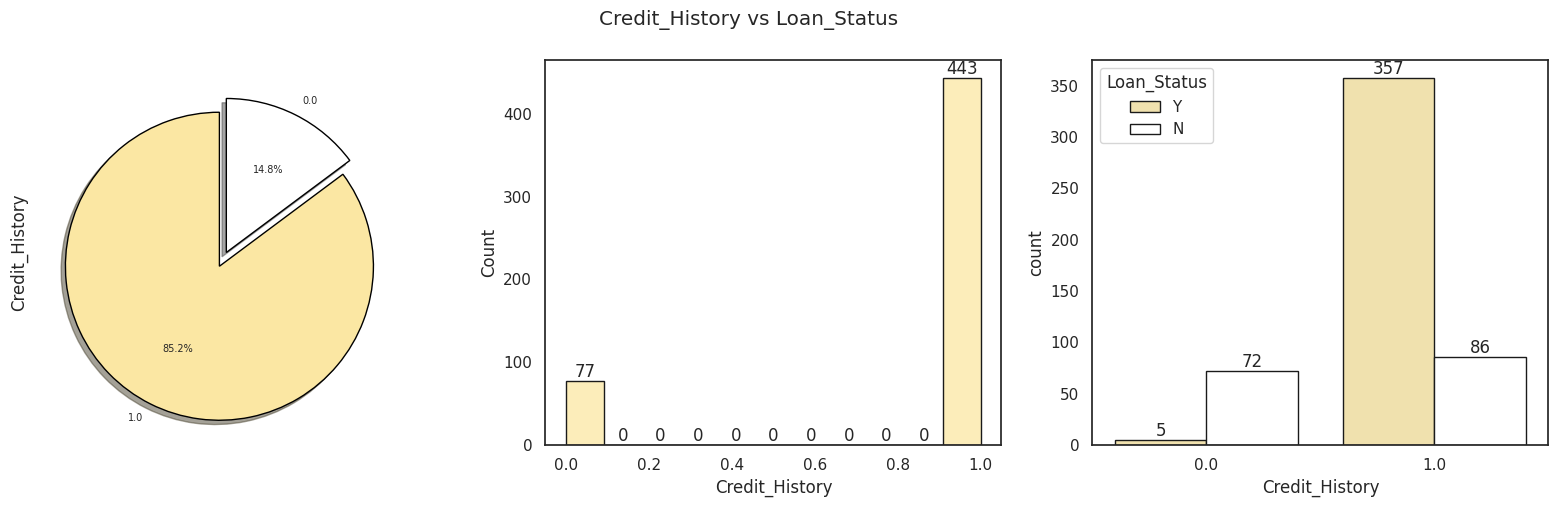

In [ ]:
catplot(df, 'Credit_History', explode = [0.1,0])

In [ ]:
approval_rate(df, 'Credit_History')

Approval rate for "Credit_History : 0.0" applicants is 6.49%
Approval rate for "Credit_History : 1.0" applicants is 80.59%


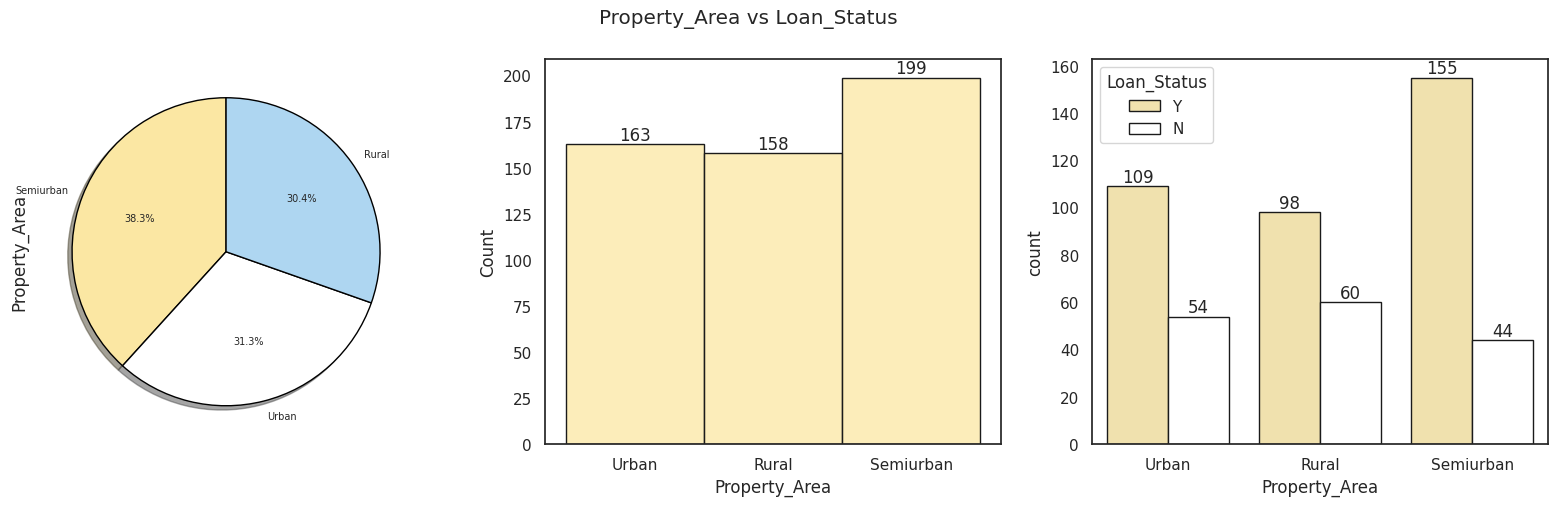

In [ ]:
catplot(df, 'Property_Area')

In [ ]:
approval_rate(df, 'Property_Area')

Approval rate for "Property_Area : Rural" applicants is 62.03%
Approval rate for "Property_Area : Semiurban" applicants is 77.89%
Approval rate for "Property_Area : Urban" applicants is 66.87%


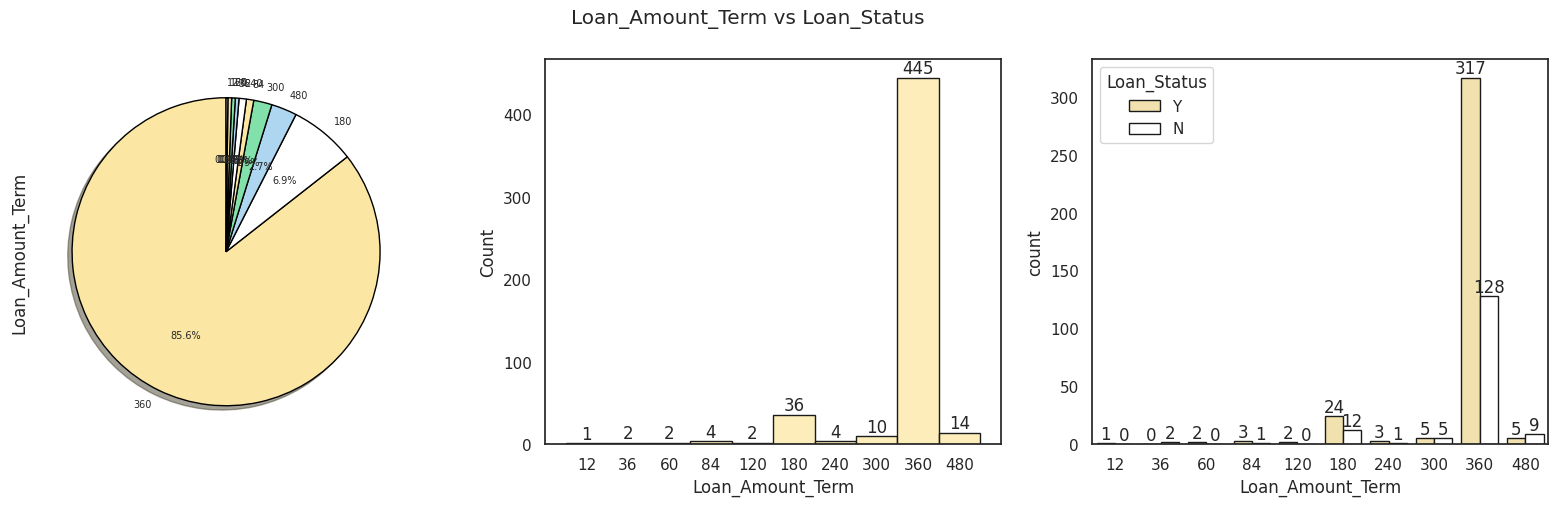

In [ ]:
dum_df = df[df['Loan_Amount_Term'].notnull()]
dum_df.sort_values(by='Loan_Amount_Term', ascending=True, inplace=True)
dum_df['Loan_Amount_Term'] = dum_df['Loan_Amount_Term'].astype(int).astype(str)

catplot(dum_df, 'Loan_Amount_Term')

In [ ]:
approval_rate(df, 'Loan_Amount_Term')

Approval rate for "Loan_Amount_Term : 12.0" applicants is 100.00%
Approval rate for "Loan_Amount_Term : 36.0" applicants is 0.00%
Approval rate for "Loan_Amount_Term : 60.0" applicants is 100.00%
Approval rate for "Loan_Amount_Term : 84.0" applicants is 75.00%
Approval rate for "Loan_Amount_Term : 120.0" applicants is 100.00%
Approval rate for "Loan_Amount_Term : 180.0" applicants is 66.67%
Approval rate for "Loan_Amount_Term : 240.0" applicants is 75.00%
Approval rate for "Loan_Amount_Term : 300.0" applicants is 50.00%
Approval rate for "Loan_Amount_Term : 360.0" applicants is 71.24%
Approval rate for "Loan_Amount_Term : 480.0" applicants is 35.71%


#Summary
1. **Gender:**
   Majority of applicants are Male (81.2%).

2. **Marital Status:**
   Majority of applicants are Married (64.6%).

3. **Dependents:**
   A significant portion of applicants do not have any dependents (60.6%).

4. **Education:**
   Most applicants hold a graduate degree (74.8%).

5. **Employment Status:**
   The majority of applicants are not self-employed (88.7%).

6. **Credit History:**
   A high percentage of applicants have a credit history (80.59%).

7. **Property Area:**
   The majority of applicants are from suburban areas (38.3%), followed by urban areas (31.3%) and rural areas (30.4%).

8. **Loan_Amount_Term:** Most of them apply for a term of 360 months (85.6%)


#Interpretation of Results:

1. **Gender :** The approval rate for female applicants is 65.31%, while for male applicants, it is higher at 70.62%. Although there is a difference, it may not be considered significant in influencing loan approval rates.

2. **Marital Status :** Married applicants have a higher approval rate (72.32%) compared to unmarried applicants (64.67%). Being married seems to positively influence the likelihood of loan approval.

3. **Dependents :** Applicants with 2 dependents have the highest approval rate (73.26%), while those with 0, 1, or 3+ dependents have approval rates ranging from 65.43% to 70.16%. Having 2 dependents appears to be more favorable for loan approval.

4. **Education :** Graduates have a significantly higher approval rate (72.75%) compared to non-graduates (60.31%). Education level seems to be a crucial factor, with graduates having a better chance of loan approval.

5. **Self-Employment :** The difference in approval rates for self-employed (67.80%) and not self-employed (69.85%) applicants is not substantial. Being self-employed or not does not appear to be a significant factor in loan approval.

6. **Credit History :** Having a positive credit history (1.0) significantly increases the chance of loan approval (80.59%), while a negative credit history (0.0) results in a much lower approval rate (6.49%). Credit history is a critical determinant of loan approval.

7. **Property Area :** Property area seems to have a notable impact on approval rates. Semiurban areas have the highest approval rate (77.89%), followed by urban areas (66.87%), and rural areas have the lowest approval rate (62.03%).

In [ ]:
#numerical column descriptive statistics after handling outliers

df.describe().T

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,520.0,3995.719231,1794.687196,150.0,2724.5,3590.5,4772.75,10047.0
CoapplicantIncome,520.0,1317.578692,1397.402837,0.0,0.0,1293.5,2191.00,5701.0
LoanAmount,520.0,124.360083,39.984816,25.0,100.0,123.0,150.00,236.0
Loan_Amount_Term,520.0,342.576923,65.618547,12.0,360.0,360.0,360.00,480.0
Credit_History,520.0,0.851923,0.355518,0.0,1.0,1.0,1.00,1.0


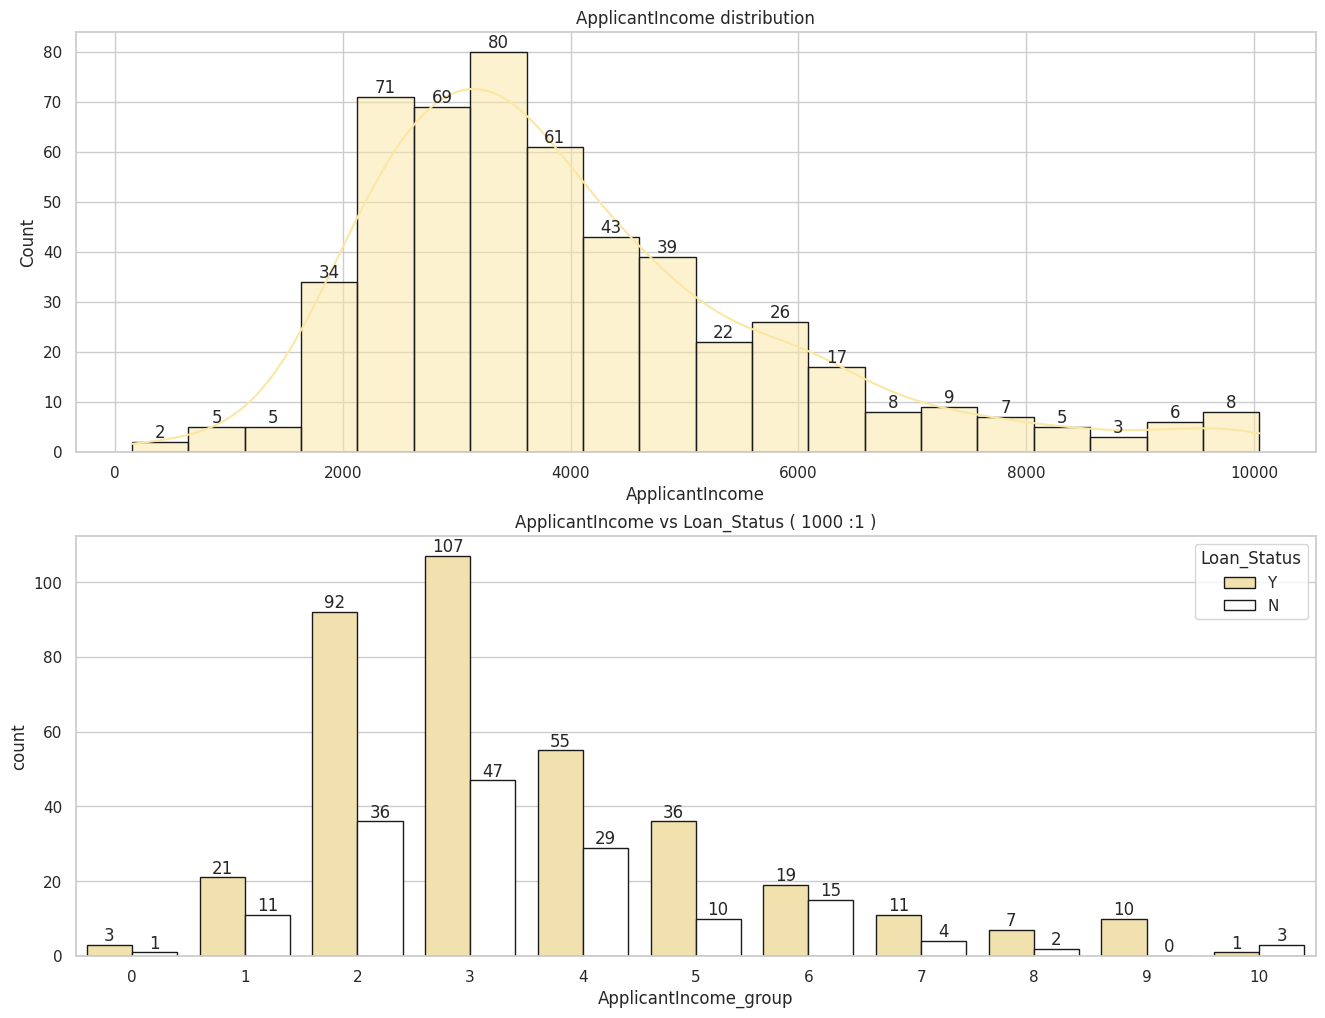

In [ ]:
numplot(df, 'ApplicantIncome', 1000)

In [ ]:
group_approval_rate(df, 'ApplicantIncome', 1000)

After grouping ApplicantIncome in 1000 scale
  Approval rate for "ApplicantIncome_group : 0" applicants is 75.00%
  Approval rate for "ApplicantIncome_group : 1" applicants is 65.62%
  Approval rate for "ApplicantIncome_group : 2" applicants is 71.88%
  Approval rate for "ApplicantIncome_group : 3" applicants is 69.48%
  Approval rate for "ApplicantIncome_group : 4" applicants is 65.48%
  Approval rate for "ApplicantIncome_group : 5" applicants is 78.26%
  Approval rate for "ApplicantIncome_group : 6" applicants is 55.88%
  Approval rate for "ApplicantIncome_group : 7" applicants is 73.33%
  Approval rate for "ApplicantIncome_group : 8" applicants is 77.78%
  Approval rate for "ApplicantIncome_group : 9" applicants is 100.00%
  Approval rate for "ApplicantIncome_group : 10" applicants is 25.00%


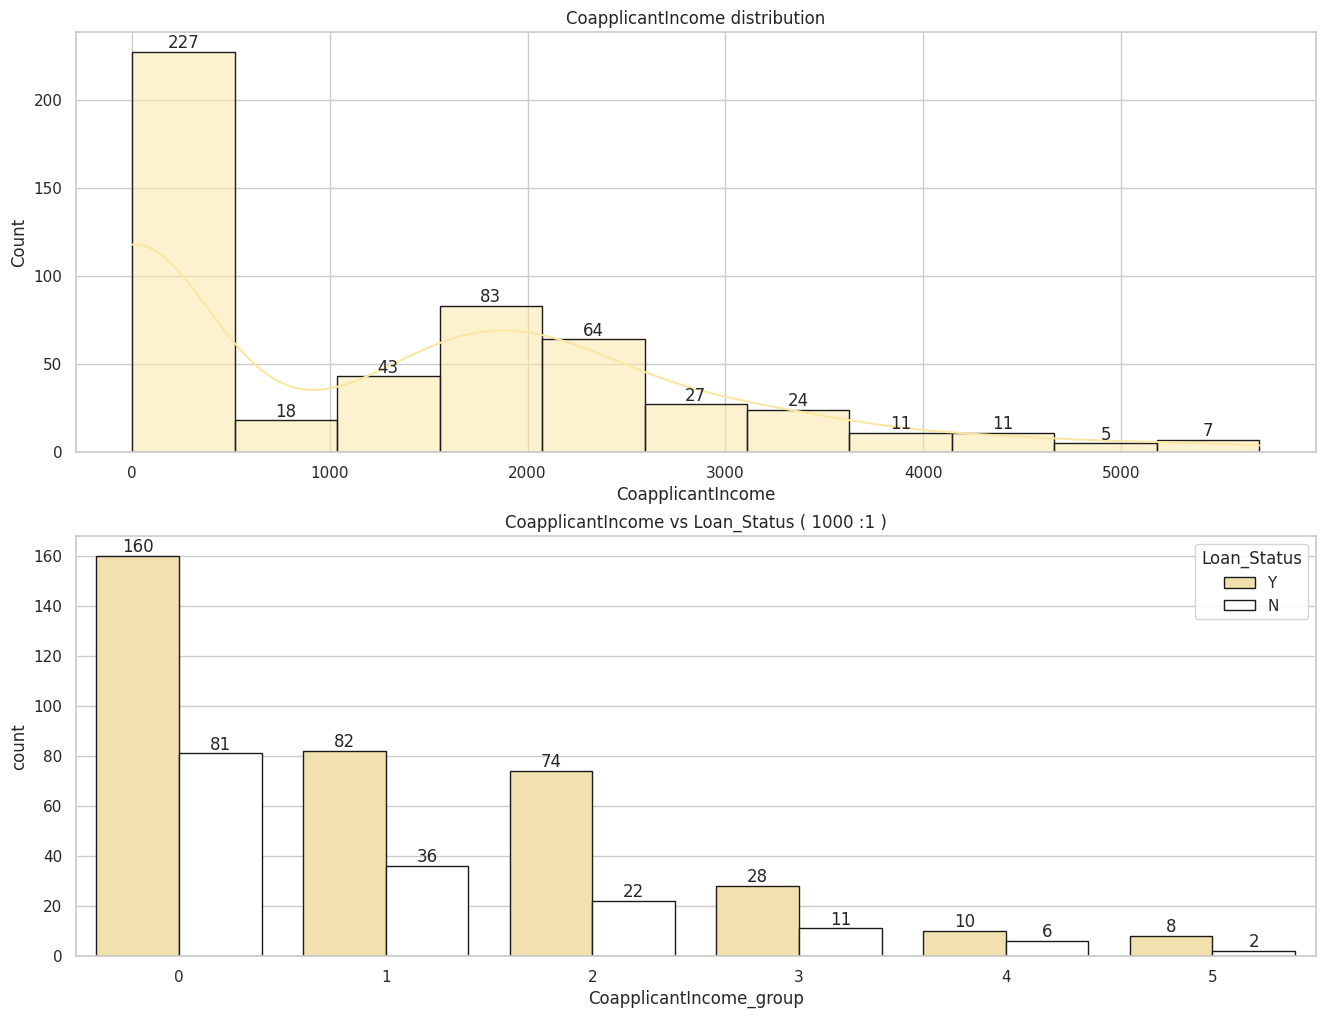

In [ ]:
numplot(df, 'CoapplicantIncome', 1000)

In [ ]:
group_approval_rate(df, 'CoapplicantIncome', 1000)

After grouping CoapplicantIncome in 1000 scale
  Approval rate for "CoapplicantIncome_group : 0" applicants is 66.39%
  Approval rate for "CoapplicantIncome_group : 1" applicants is 69.49%
  Approval rate for "CoapplicantIncome_group : 2" applicants is 77.08%
  Approval rate for "CoapplicantIncome_group : 3" applicants is 71.79%
  Approval rate for "CoapplicantIncome_group : 4" applicants is 62.50%
  Approval rate for "CoapplicantIncome_group : 5" applicants is 80.00%


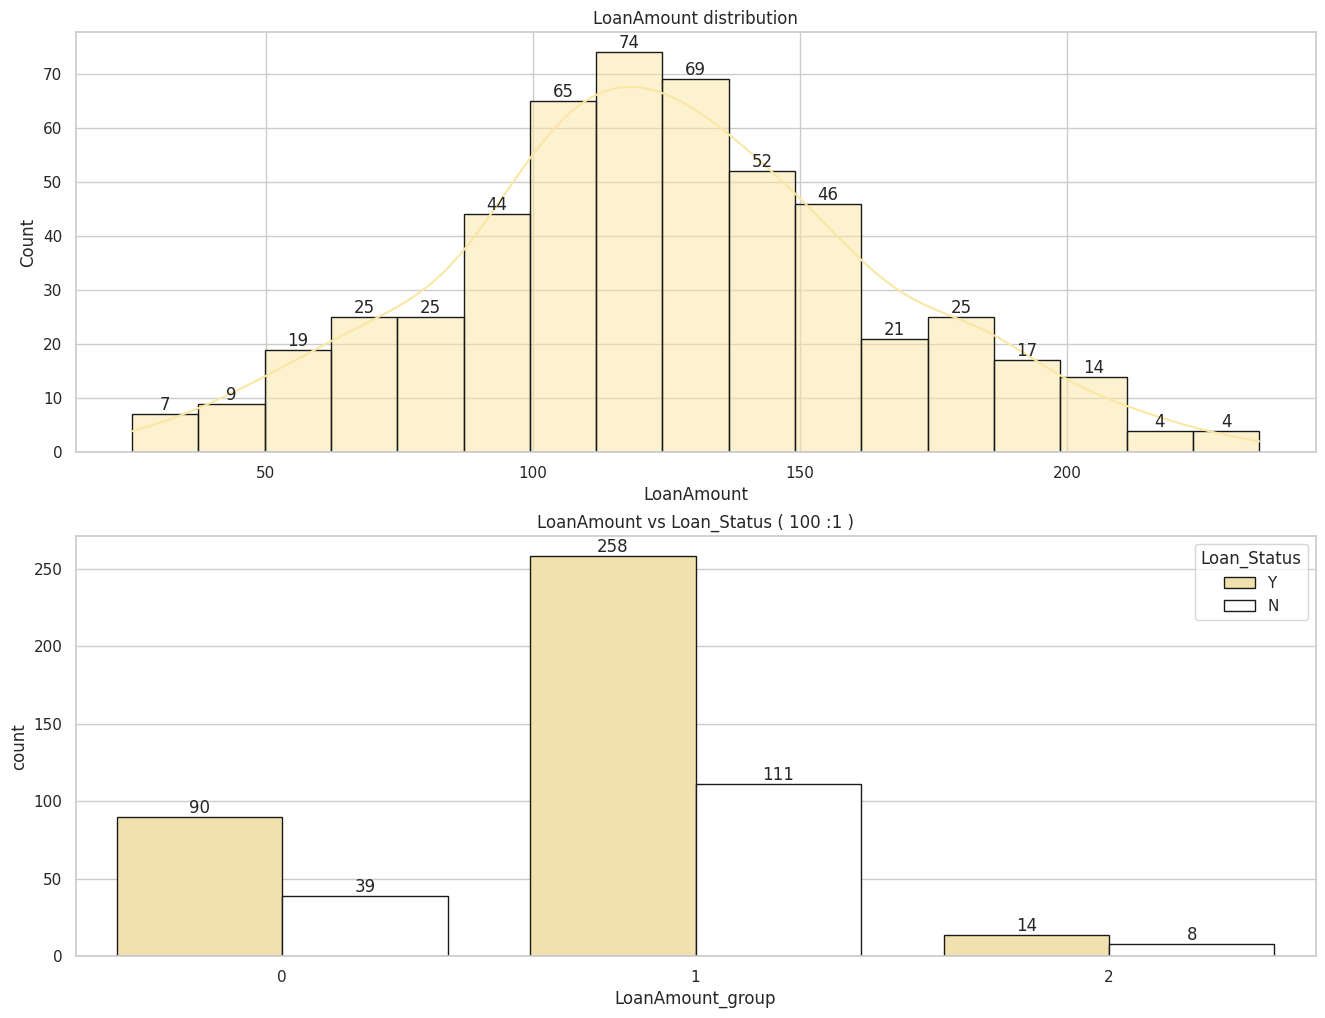

In [ ]:
numplot(df[df['LoanAmount'].notnull()], 'LoanAmount', 100)

In [ ]:
group_approval_rate(df, 'LoanAmount', 100)

After grouping LoanAmount in 100 scale
  Approval rate for "LoanAmount_group : 0" applicants is 69.77%
  Approval rate for "LoanAmount_group : 1" applicants is 69.92%
  Approval rate for "LoanAmount_group : 2" applicants is 63.64%


Your summary is well-structured and provides clear information. However, I'd like to suggest a few grammatical edits for improved clarity:

# Summary

1. **ApplicantIncome:** The distribution of ApplicantIncome is right-skewed, indicating a concentration of values towards the lower end. It is characterized by a mean of 3995.72 and a standard deviation of 1794.69. The minimum income is 150, while the maximum is 10047.0.

2. **CoapplicantIncome:** Similar to ApplicantIncome, the distribution of CoapplicantIncome is right-skewed, suggesting a concentration of lower coapplicant incomes. Here, the mean is 1317.58, and the standard deviation is 1397.40. The distribution ranges from 0 to 5701.0. And most of the applicants do not have coapplicant income.

3. **LoanAmount:** The distribution of LoanAmount is characterized by a mean of 124.36 and a standard deviation of 39.98. The loan amounts range from 25.0 to 236.0. Unlike income variables, the distribution appears relatively symmetric, as suggested by the mean being close to the median (123.0).

#Inference
1. **Applicant Income:** When grouped on a scale of 100, majority of applicants fall into groups 2 and 3, with an approval rate of approximately 70%.

2. **Coapplicant Income:** When grouped on a scale of 100, the predominant group for coapplicant income is group 0, having an approval rate of 66.39%.

3. **Loan Amount:** When grouped on a scale of 100, the highest concentration of loan amounts is in group 1, accompanied by an approval rate of 69.91%.




#Testing of hypothesis

In [ ]:
#UDF for Chi-Square Test of Independence

def chi2_test(col1,col2):
  contingency_table = pd.crosstab(df[col1], df[col2])
  chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
  display(contingency_table)
  print('\nP-value: ', p_val)
  if p_val <= 0.05:
    print('We reject the null hypothesis.')
  else:
    print('We fail to reject the null hypothesis.')

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------



**Question 1**:
  Does Gender have a significant impact on Loan Approval Status?
\
\
Null Hypothesis ($H_0$) : There is no association between Gender and Loan Approval Status.

Alternative Hypothesis ($H_1$) : There is an association between Gender and Loan Approval Status.

Significance Level ($\alpha$) : 0.05

Test : Chi-Square Test of Independence

After performing the Chi-Square Test, you will assess the p-value. If the p-value is less than or equal to the significance level (0.05), you will reject the null hypothesis, suggesting that there is evidence of an association between Gender and Loan Approval Status.

In [ ]:
chi2_test('Gender','Loan_Status')

Loan_Status,N,Y
Gender,,
Female,34,64
Male,124,298



P-value:  0.36402282957717125
We fail to reject the null hypothesis.


With a p-value of 0.3640, which is greater than the significance level ($\alpha$ = 0.05), We fail to reject the null hypothesis. This suggests that there is insufficient evidence to claim an association between Gender and Loan Approval Status.



--------------------------------------------------------------------------------

--------------------------------------------------------------------------------


**Question 2**:
  Does Marital Status have a significant impact on Loan Approval Status?
\
\
Null Hypothesis ($H_0$) : There is no association between Marital Status and Loan Approval Status.

Alternative Hypothesis ($H_1$) : There is an association between Marital Status and Loan Approval Status.

Significance Level ($\alpha$) : 0.05

Test : Chi-Square Test of Independence

After performing the Chi-Square Test, you will assess the p-value. If the p-value is less than or equal to the significance level (0.05), you will reject the null hypothesis, suggesting that there is evidence of an association between Marital Status and Loan Approval Status.

In [ ]:
chi2_test('Married','Loan_Status')

Loan_Status,N,Y
Married,,
No,65,119
Yes,93,243



P-value:  0.08664282432719576
We fail to reject the null hypothesis.


With a p-value of 0.0866, which is greater than the significance level ($\alpha$ = 0.05), We fail to reject the null hypothesis. This suggests that there is insufficient evidence to claim an association between Marital Status and Loan Approval Status.

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------


**Question 3**:
  Does No. of Dependents have a significant impact on Loan Approval Status?
\
\
Null Hypothesis ($H_0$) : There is no association between No. of Dependents and Loan Approval Status.

Alternative Hypothesis ($H_1$) : There is an association between No. of Dependents and Loan Approval Status.

Significance Level ($\alpha$) : 0.05

Test : Chi-Square Test of Independence

After performing the Chi-Square Test, you will assess the p-value. If the p-value is less than or equal to the significance level (0.05), you will reject the null hypothesis, suggesting that there is evidence of an association between No. of Dependents and Loan Approval Status.

In [ ]:
chi2_test('Dependents','Loan_Status')

Loan_Status,N,Y
Dependents,,
0,94,221
1,28,53
2,23,63
3+,13,25



P-value:  0.6786096772268975
We fail to reject the null hypothesis.


With a p-value of 0.6786, which is greater than the significance level ($\alpha$ = 0.05), We fail to reject the null hypothesis. This suggests that there is insufficient evidence to claim an association between No. of Dependents and Loan Approval Status.

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

**Question 4** : Does Education have a significant impact on Loan Approval Status?
\
\
Null Hypothesis ($H_0$) : There is no association between Education and Loan Approval Status

Alternate Hypothesis ($H_1$) : There is an association between Education and Loan Approval Status

Significance Level ($\alpha$) : 0.05

Test :Chi-Square Test of Independence

After performing the Chi-Square Test, assess the p-value. If the p-value is less than or equal to the significance level (0.05), reject the null hypothesis, suggesting evidence of an association between Education and Loan Approval Status.


In [ ]:
chi2_test('Education','Loan_Status')

Loan_Status,N,Y
Education,,
Graduate,106,283
Not Graduate,52,79



P-value:  0.010200863911832607
We reject the null hypothesis.


With a p-value of 0.0102, which is less than the significance level (α=0.05), we reject the null hypothesis.

In practical terms, the result implies that, based on the data and the chosen significance level, there is a significant impact of Education on Loan Approval Status. The rejection of the null hypothesis indicates that the two variables, Education and Loan Approval Status, are associated.



--------------------------------------------------------------------------------

-------------------------------------------------------------------------------

**Question 5** : Does Self Employment Status have a significant impact on Loan Approval Status?
\
\
Null Hypothesis ($H_0$) : There is no association between Self Employment Status and Loan Approval Status

Alternate Hypothesis ($H_1$) : There is an association between Self Employment Status and Loan Approval Status

Significance Level ($\alpha$) : 0.05

Test :Chi-Square Test of Independence

After performing the Chi-Square Test, assess the p-value. If the p-value is less than or equal to the significance level (0.05), reject the null hypothesis, suggesting evidence of an association between Self Employment Status and Loan Approval Status.


In [ ]:
chi2_test('Self_Employed','Loan_Status')

Loan_Status,N,Y
Self_Employed,,
No,139,322
Yes,19,40



P-value:  0.8632099923524893
We fail to reject the null hypothesis.


With a p-value of 0.86, which is greater than the significance level ($\alpha$ = 0.05), We fail to reject the null hypothesis. This suggests that there is insufficient evidence to claim an association between Self Employment Status and Loan Approval Status.

--------------------------------------------------------------------------------

-------------------------------------------------------------------------------

**Question 6** : Does Credit History have a significant impact on Loan Approval Status?
\
\
Null Hypothesis ($H_0$) : There is no association between Credit History and Loan Approval Status

Alternate Hypothesis ($H_1$) : There is an association between Credit History and Loan Approval Status

Significance Level ($\alpha$) : 0.05

Test :Chi-Square Test of Independence

After performing the Chi-Square Test, assess the p-value. If the p-value is less than or equal to the significance level (0.05), reject the null hypothesis, suggesting evidence of an association between Credit History and Loan Approval Status.


In [ ]:
chi2_test('Credit_History','Loan_Status')

Loan_Status,N,Y
Credit_History,,
0.0,72,5
1.0,86,357



P-value:  3.7616148852325344e-38
We reject the null hypothesis.


We reject the null hypothesis. There is strong evidence of an association between Credit History and Loan Approval Status. The extremely low p-value (3.76e-40) suggests a highly significant relationship between having a credit history (1.0) and loan approval.

-------------------------------------------------------------------------------

-------------------------------------------------------------------------------

**Question 7** : Does Property Area have a significant impact on Loan Approval Status?
\
\
Null Hypothesis ($H_0$) :  There is no association between Property Area and Loan Approval Status

Alternate Hypothesis ($H_1$) :  There is an association between Property Area and Loan Approval Status

Significance Level ($\alpha$) : 0.05

Test : Chi-Square Test of Independence

After performing the Chi-Square Test, assess the p-value. If the p-value is less than or equal to the significance level (0.05), reject the null hypothesis, suggesting evidence of an association between Property Area and Loan Approval Status.

In [ ]:
chi2_test('Property_Area','Loan_Status')

Loan_Status,N,Y
Property_Area,,
Rural,60,98
Semiurban,44,155
Urban,54,109



P-value:  0.003475250234801341
We reject the null hypothesis.


With a p-value of 0.0034, which is less than the significance level (α=0.05), we reject the null hypothesis.

In practical terms, the result implies that, based on the data and the chosen significance level, there is a significant impact of Property Area on Loan Approval Status. The rejection of the null hypothesis indicates that the two variables, Property Area and Loan Approval Status, are associated.



--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

#Interpretation:
1. **Gender :** No significant association found between Gender and Loan Approval.
2. **Married :** No significant association found between Marital Status and Loan Approval.
3. **Dependents :** No significant evidence of association based on the number of Dependents.
4. **Education :** Evidence indicates an association between Education and Loan Approval.
5. **Self_Employed :** No significant association found with Self Employment Status.
6. **Credit_History :** Strong evidence of an association between Credit History and Loan Approval.
7. **Property_Area :** Evidence suggests an association between Property Area and Loan Approval.

#Data Preprocessing

1. Encoding Categorical variables

In [ ]:
#code to get the categorical columns

categorical_columns = df.select_dtypes(include=['object', 'category']).columns
categorical_columns = categorical_columns.drop('Loan_Status')
print(categorical_columns)

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Property_Area'],
      dtype='object')


In [ ]:
#Label Encoding the categorical variables and reate a dictionary to store encoders

label_encoders = {}

for column in categorical_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

In [ ]:
#Encoding the dependent variable

df['Loan_Status'] = df['Loan_Status'].map({'Y' : 1, 'N' : 0})

In [ ]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,0,0,0,0,5849,0.0,146.412162,360.0,1.0,2,1
1,1,1,1,0,0,4583,1508.0,128.000000,360.0,1.0,0,0
2,1,1,0,0,1,3000,0.0,66.000000,360.0,1.0,2,1
3,1,1,0,1,0,2583,2358.0,120.000000,360.0,1.0,2,1
4,1,0,0,0,0,6000,0.0,141.000000,360.0,1.0,2,1


2. Train Test Split

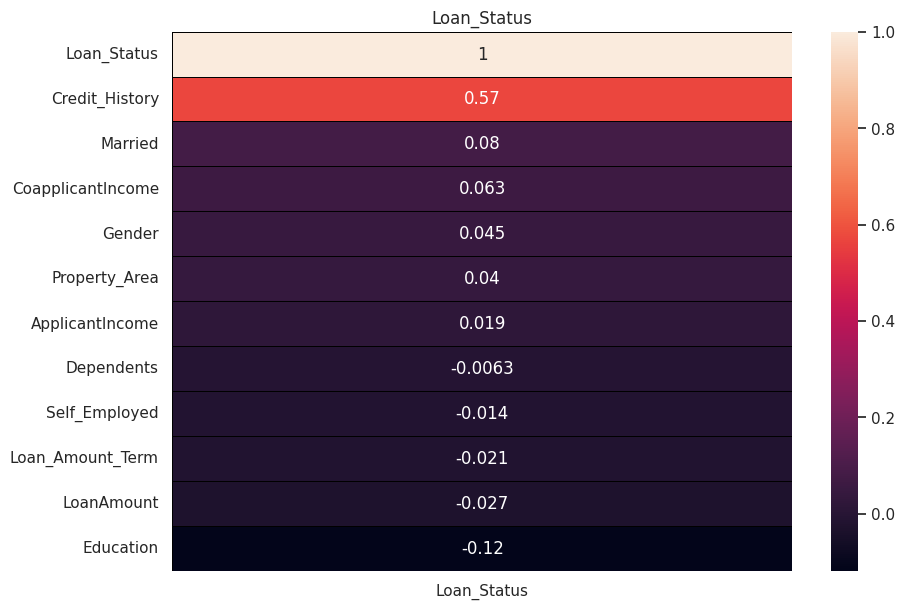

In [ ]:
#visualize the correlation of independent variables with dependent variable

corr = df.corrwith(df['Loan_Status']).sort_values(ascending = False).to_frame()
corr.columns = ['Loan_Status']
plt.figure(figsize=(10,7))
sns.heatmap(corr,annot=True,linewidths=0.4,linecolor='black')

plt.title('Loan_Status')
plt.show()

Based on the correlation plot, it is very clear that Credit History has a very high correlation with Loan Approval Status

In [ ]:
#Split dependent and independent variables

X = df.drop(['Loan_Status'],axis = 1)
y = df['Loan_Status']

In [ ]:
#train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify = y, random_state=42)

3. Scaling

In [ ]:
#scale features using Standard Scalar

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

4. Handling Imbalance data

In [ ]:
#Oversampling the data using SMOTE to ensure that the classes in the target variable are represented equally.

print("Before OverSampling, counts of label 'Y': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label 'N': {}".format(sum(y_train == 0)))

sm = SMOTE(random_state = 0)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

print("After OverSampling, counts of label 'Y': {}".format(sum(y_train_resampled == 0)))
print("After OverSampling, counts of label 'N': {}".format(sum(y_train_resampled == 1)))

Before OverSampling, counts of label 'Y': 272
Before OverSampling, counts of label 'N': 118
After OverSampling, counts of label 'Y': 272
After OverSampling, counts of label 'N': 272


#Model Building and Evaluation

In [ ]:
classifiers = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('KNN', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('AdaBoost', AdaBoostClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('XGBoost', XGBClassifier()),
    ('LightGBM', LGBMClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('SVM', SVC()),
    ('MLP', MLPClassifier()),
    ('Gaussian Process', GaussianProcessClassifier()),
    ('Bagging', BaggingClassifier()),
]

# Define the evaluation metrics
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Evaluate each classifier using cross-validation
results = []
for name, clf in classifiers:
    cv_results = cross_validate(clf, X_train_resampled, y_train_resampled, scoring=scoring, cv=5, return_train_score=False)
    acc = cv_results['test_accuracy'].mean()
    pre = cv_results['test_precision'].mean()
    rec = cv_results['test_recall'].mean()
    f1 = cv_results['test_f1'].mean()
    roc = cv_results['test_roc_auc'].mean()
    results.append((name, acc, pre, rec, f1, roc))

# Create a dataframe with the results and sort it by the weighted score
df_results = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC_AUC'])

# Sort the results by the weighted score
df_results.sort_values(by=['Accuracy'], ascending=False, inplace=True)

df_results.reset_index()

[LightGBM] [Info] Number of positive: 217, number of negative: 218
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number of data points in the train set: 435, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498851 -> initscore=-0.004598
[LightGBM] [Info] Start training from score -0.004598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

,index,Classifier,Accuracy,Precision,Recall,F1-score,ROC_AUC
0,3,Random Forest,0.847537,0.824386,0.904444,0.859086,0.918853
1,6,XGBoost,0.843884,0.831724,0.889764,0.855386,0.907273
2,11,Gaussian Process,0.843782,0.830110,0.867879,0.847760,0.905623
3,7,LightGBM,0.825450,0.812568,0.864108,0.834390,0.901943
4,5,Gradient Boosting,0.818145,0.790335,0.893266,0.834675,0.887527
5,1,KNN,0.810720,0.807524,0.816566,0.811152,0.886563
6,12,Bagging,0.803313,0.797991,0.827071,0.809229,0.886910
7,10,MLP,0.801444,0.774156,0.860404,0.813444,0.861247
8,2,Decision Tree,0.794173,0.813511,0.786869,0.795507,0.793805
9,9,SVM,0.779426,0.723889,0.908148,0.804815,0.853554


The best model for this dataset is the Random Forest Classifier, which exhibits relatively higher accuracy compared to other models.

In [ ]:
#Fitting and evaluating on test data

RandomForest = RandomForestClassifier()

RandomForest.fit(X_train_resampled, y_train_resampled)
y_pred = RandomForest.predict(X_test)

print("Accuracy score : ",accuracy_score(y_pred,y_test))
print("precision score : ",precision_score(y_pred,y_test))
print("recall score : ",recall_score(y_pred,y_test))
print("f1 score : ",f1_score(y_pred,y_test))
print("\nclassification report \n")
print(classification_report(y_pred,y_test))

Accuracy score :  0.7692307692307693
precision score :  0.8888888888888888
recall score :  0.8
f1 score :  0.8421052631578948

classification report 

              precision    recall  f1-score   support

           0       0.50      0.67      0.57        30
           1       0.89      0.80      0.84       100

    accuracy                           0.77       130
   macro avg       0.69      0.73      0.71       130
weighted avg       0.80      0.77      0.78       130



#Hyper parameter tuning using optuna

In [ ]:
# Define an objective function for Optuna to maximize

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample', None]),
        'random_state': trial.suggest_int('random_state', 0, 100)
    }

    clf = RandomForestClassifier(**params)
    clf.fit(X_train_resampled, y_train_resampled)

    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-01-09 08:44:15,673] A new study created in memory with name: no-name-c7adb282-afaa-4d58-a2b3-6604ffebdf19
[I 2024-01-09 08:44:16,808] Trial 0 finished with value: 0.7692307692307693 and parameters: {'n_estimators': 526, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'entropy', 'class_weight': None, 'random_state': 67}. Best is trial 0 with value: 0.7692307692307693.
[I 2024-01-09 08:44:18,407] Trial 1 finished with value: 0.8 and parameters: {'n_estimators': 748, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'entropy', 'class_weight': 'balanced', 'random_state': 3}. Best is trial 1 with value: 0.8.
[I 2024-01-09 08:44:19,579] Trial 2 finished with value: 0.8076923076923077 and parameters: {'n_estimators': 423, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'entr

In [ ]:
# Print the best set of hyperparameters and the corresponding accuracy
print('Best set of hyperparameters: ', study.best_params)
print('Best accuracy: ', study.best_value)

Best set of hyperparameters:  {'n_estimators': 973, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'gini', 'class_weight': None, 'random_state': 13}
Best accuracy:  0.8153846153846154


The best hyperparameters and the best accuracy is obtained by optuna

#Model building and evaluation with best hyperparameters

In [ ]:
RandomForest = RandomForestClassifier(**study.best_params)

RandomForest.fit(X_train_resampled, y_train_resampled)
y_pred = RandomForest.predict(X_test)

print("Accuracy score : ",accuracy_score(y_pred,y_test))
print("precision score : ",precision_score(y_pred,y_test))
print("recall score : ",recall_score(y_pred,y_test))
print("f1 score : ",f1_score(y_pred,y_test))
print("\nclassification report \n")
print(classification_report(y_pred,y_test))

Accuracy score :  0.8153846153846154
precision score :  0.9333333333333333
recall score :  0.8235294117647058
f1 score :  0.8749999999999999

classification report 

              precision    recall  f1-score   support

           0       0.55      0.79      0.65        28
           1       0.93      0.82      0.87       102

    accuracy                           0.82       130
   macro avg       0.74      0.80      0.76       130
weighted avg       0.85      0.82      0.83       130



#Feature Importance from the fitted algorithm

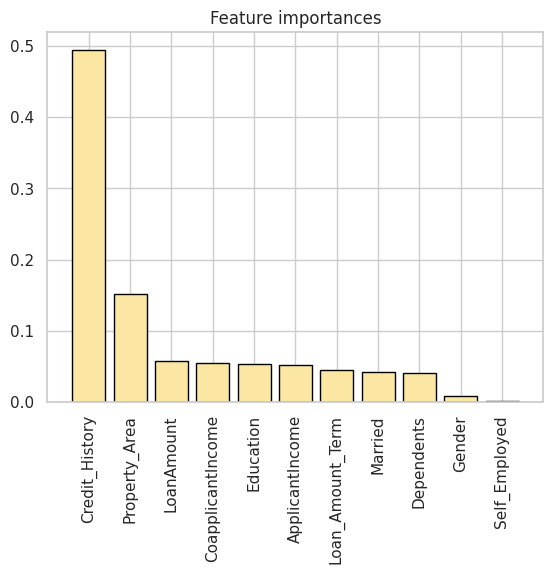

In [ ]:
importances = RandomForest.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="#FBE7A3", align="center", edgecolor="black")
plt.xticks(range(X_train.shape[1]), df.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

The feature importance analysis indicates that Credit_History and Property_Area are the most influential factors, significantly impacting the model's predictions. In contrast, Gender and Self_Employed contribute minimally. The model emphasizes credit history and property area in determining loan approval likelihood.

#Creating pickle files for deployment

In [ ]:
#Save the label encoder to a pickle file
with open('encoder.pkl', 'wb') as file:
    pickle.dump(label_encoders, file)

# Save the scaler to a pickle file
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

# Save the Random Forest model to a pickle file
with open('model.pkl', 'wb') as file:
    pickle.dump(RandomForest, file)

In [ ]:
import sklearn
sklearn.__version__

'1.2.2'